<a href="https://colab.research.google.com/github/michalinahulak/lending_club/blob/main/lending_club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Image(url='https://mma.prnewswire.com/media/76307/lending_club_logo.jpg?p=facebook', width=600)

# What is Lending Club?
LendingClub is a financial services company based in San Francisco, California. It was the first peer-to-peer lending platform to register its offerings as securities with the SEC and introduced loan trading on a secondary market. At its peak, LendingClub was the world's largest peer-to-peer lending platform. The company facilitated unsecured personal loans ranging from 1,000 to 40,000 $, with a standard loan period of three years. Investors could browse and select loans to invest in based on borrower information and loan details. LendingClub earned revenue through borrower origination fees and investor service fees. In addition to peer-to-peer lending, LendingClub also offers direct-to-consumer loans through WebBank. The company faced challenges in 2016 due to investor attrition, loan scandals, and disclosure concerns, resulting in a drop in share price and the CEO's resignation. In 2020, LendingClub acquired Radius Bank and shifted its focus away from peer-to-peer lending, discontinuing new loans and secondary marketplace transactions.

# Dataset description
The dataset "accepted_2007_to_2018q4.csv" contains data related to accepted loans from LendingClub, covering the period from 2007 to the fourth quarter of 2018.

* acc_now_delinq: The number of accounts on which the borrower is currently delinquent.
* addr_state: The state provided by the borrower in the loan application.
* annual_inc: The self-reported annual income provided by the borrower during registration.
* application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers.
* dti: The debt-to-income ratio calculated using the borrower's total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower's self-reported monthly income.
* emp_length: Employment length in years. Possible values range from 0 to 10, where 0 means less than one year and 10 means ten or more years.
* grade: The assigned grade of the loan by LC.
* home_ownership: The home ownership status provided by the borrower during registration.
* initial_list_status: The initial listing status of the loan.
* installment: The monthly payment amount the borrower is obligated to repay if the loan is granted.
* int_rate: The interest rate of the loan.
* loan_amnt: The listed amount of the loan applied for by the borrower.
* loan_status: The current status of the loan.
* purpose

In [ ]:
!pip install kaggle
!pip install pyspark

# Imports

In [44]:
import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt

from IPython.display import Image

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, regexp_extract
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, IntegerType

from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split


# Functions

In [3]:
def one_hot_encode_column(df, input_col):
    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + '_indexed')
    indexed_df = indexer.fit(df).transform(df)

    encoder = OneHotEncoder(inputCol=input_col + '_indexed', outputCol=input_col + '_encoded')
    encoded_df = encoder.fit(indexed_df).transform(indexed_df)

    encoded_df = encoded_df.drop(input_col, input_col + '_indexed')

    return encoded_df

#Upload dataset

In [4]:
spark = SparkSession.builder \
    .appName("Aplikacja") \
    .getOrCreate()

In [ ]:
#please upload your kaggle API (kaggle.json)

from google.colab import files
files.upload()

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wordsforthewise/lending-club

100% 1.26G/1.26G [00:11<00:00, 161MB/s]
100% 1.26G/1.26G [00:11<00:00, 122MB/s]


In [7]:
#unzip
zip_file_path = '/content/lending-club.zip'
extract_dir = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("File has been extracted.")

File has been extracted.


In [8]:
selected_columns = [
    "id",
    "purpose",
    "term",
    "verification_status",
    "acc_now_delinq",
    "addr_state",
    "annual_inc",
    "application_type",
    "dti",
    "grade",
    "home_ownership",
    "initial_list_status",
    "installment",
    "int_rate",
    "loan_amnt",
    "loan_status"
]

df = spark.read.csv('/content/dataset/accepted_2007_to_2018q4.csv', header=True).select(selected_columns)
df.limit(5).toPandas()

,id,purpose,term,verification_status,acc_now_delinq,addr_state,annual_inc,application_type,dti,grade,home_ownership,initial_list_status,installment,int_rate,loan_amnt,loan_status
0,68407277,debt_consolidation,36 months,Not Verified,0.0,PA,55000.0,Individual,5.91,C,MORTGAGE,w,123.03,13.99,3600.0,Fully Paid
1,68355089,small_business,36 months,Not Verified,0.0,SD,65000.0,Individual,16.06,C,MORTGAGE,w,820.28,11.99,24700.0,Fully Paid
2,68341763,home_improvement,60 months,Not Verified,0.0,IL,63000.0,Joint App,10.78,B,MORTGAGE,w,432.66,10.78,20000.0,Fully Paid
3,66310712,debt_consolidation,60 months,Source Verified,0.0,NJ,110000.0,Individual,17.06,C,MORTGAGE,w,829.9,14.85,35000.0,Current
4,68476807,major_purchase,60 months,Source Verified,0.0,PA,104433.0,Individual,25.37,F,MORTGAGE,w,289.91,22.45,10400.0,Fully Paid


# EDA

## Missing values

In [9]:
null_counts = df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+
| id|purpose|term|verification_status|acc_now_delinq|addr_state|annual_inc|application_type| dti|grade|home_ownership|initial_list_status|installment|int_rate|loan_amnt|loan_status|
+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+
|  0|     34|  33|                 33|           221|        34|        37|              88|1745|   33|            33|                 50|         33|      33|       33|         33|
+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+



In [10]:
df = df.na.drop()

## 'purpose'

In [11]:
df_with_count = df.groupBy('purpose').count()
df_with_count.show()

+--------------------+-------+
|             purpose|  count|
+--------------------+-------+
|             wedding|   2351|
|               other| 139278|
|      small_business|  24642|
|  debt_consolidation|1276794|
|         credit_card| 516592|
|              moving|  15371|
|            vacation|  15520|
|    renewable_energy|   1444|
|               house|  14120|
|                 car|  23998|
|      major_purchase|  50400|
|             medical|  27453|
|    home_improvement| 150297|
|         educational|    412|
| which is $250 a ...|      1|
| so that our comp...|      1|
| progressive mult...|      1|
| and extremely se...|      1|
| on one of the bu...|      1|
| my monthly budge...|      1|
+--------------------+-------+
only showing top 20 rows



In [12]:
# Replacing values in the 'purpose' column based on the 'count' column condition
# If 'count' is less than 300, set 'purpose' to "other", else keep the original 'purpose'

df = df\
.join(df_with_count, on='purpose', how='left')\
.withColumn("purpose", when(col("count") < 300, "other").otherwise(col("purpose")))\
.drop('count')

In [13]:
unique_purposes = df.select("purpose").distinct()
unique_purposes.show()

+------------------+
|           purpose|
+------------------+
|           wedding|
|       educational|
|             other|
|    small_business|
|debt_consolidation|
|       credit_card|
|            moving|
|          vacation|
|  renewable_energy|
|             house|
|               car|
|    major_purchase|
|           medical|
|  home_improvement|
+------------------+



## 'term'

In [14]:
df.groupby('term').count()\
.show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1608560|
| 60 months| 650198|
+----------+-------+



In [15]:
# Applying a regular expression to extract numbers from the 'term' column and then casting it to the Integer data type.

df = df\
.withColumn("term", regexp_extract(col("term"), r'(\d+)', 0).cast("int"))

## 'verification_status'

In [16]:
df.groupby('verification_status').count()\
.show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|629413|
|    Source Verified|886153|
|       Not Verified|743192|
+-------------------+------+



In [17]:
# Encode 'verification_status' column values into a new column 'verification_status_encoded'
# If 'verification_status' is either "Verified" or "Source Verified", set 'verification_status_encoded' to 0
# Otherwise, set it to 1

df = df\
.withColumn("verification_status_encoded",
            when(col("verification_status")
                 .isin(["Verified", "Source Verified"]),0)
            .otherwise(1))\
.drop("verification_status")

## 'acc_now_delinq'


In [18]:
df.groupby('acc_now_delinq').count()\
.show()

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|           1.0|   8307|
|           0.0|2249899|
|           5.0|      3|
|           4.0|     11|
|           2.0|    421|
|           3.0|     50|
|          14.0|      1|
|           6.0|      2|
|           7.0|      1|
|         705.0|      1|
|         654.0|      1|
|             f|      2|
|    Individual|     22|
|      Jul-2016|      1|
|         534.0|      1|
|      Feb-2013|      2|
|        439.64|      1|
|        300.16|      1|
|         755.0|      1|
|      Mar-2012|      1|
+--------------+-------+
only showing top 20 rows



In [19]:
# Define the valid values for 'acc_now_delinq'
valid_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Modify the 'acc_now_delinq' column:
# 1. Cast the column to IntegerType
# 2. Set values greater than or equal to 4 to 4, and keep other valid values as they are
df = df.withColumn('acc_now_delinq', col('acc_now_delinq').cast('int')) \
       .withColumn('acc_now_delinq', when(col('acc_now_delinq') >= 4, 4).otherwise(col('acc_now_delinq'))) \
       .filter(col('acc_now_delinq').isin(valid_values))

In [20]:
df.groupby('acc_now_delinq').count()\
.show()

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|             1|   8307|
|             3|     50|
|             4|     49|
|             2|    421|
|             0|2249899|
+--------------+-------+



## 'application_type'

In [21]:
df.groupby('application_type').count()\
.show()

+------------------+-------+
|  application_type|  count|
+------------------+-------+
|         Joint App| 118999|
|        Individual|2139673|
|          Apr-2013|      1|
|             764.0|      1|
|            202.59|      1|
|            8336.9|      1|
|               0.0|      5|
|           1588.21|      1|
|14067.080942648401|      1|
|             779.0|      1|
|             769.0|      1|
|             659.0|      1|
|          Apr-2012|      1|
|             844.0|      1|
|          Feb-2012|      1|
|          Jan-2012|      1|
|          May-2010|      1|
|          Jul-2010|      1|
| 8541.663712072801|      1|
|          Feb-2011|      1|
+------------------+-------+
only showing top 20 rows



In [22]:
# Define the valid values for 'application_type'
valid_values = ['Joint App', 'Individual']

# Modify the 'application_type' column:
# 1. Map 'Joint App' to 0 and 'Individual' to 1
# 2. Remove other values
# 3. Cast the column to IntegerType

df = df.withColumn('application_type',
                   when(col('application_type') == 'Joint App', 0)
                   .when(col('application_type') == 'Individual', 1)
                   .otherwise(None))

df = df.filter(col('application_type').isNotNull()).withColumn('application_type', col('application_type').cast('int'))

## 'grade'

In [23]:
df.groupby('grade').count()\
.show()

+-----+------+
|grade| count|
+-----+------+
|    F| 41764|
|    E|135516|
|    B|663025|
|    D|324054|
|    C|649486|
|    A|432681|
|    G| 12146|
+-----+------+



In [24]:
# Create a StringIndexer to convert 'grade' column into numerical indices
grade_indexer = StringIndexer(inputCol="grade", outputCol="grade_index", stringOrderType="alphabetAsc")

df = grade_indexer\
.fit(df)\
.transform(df)\
.drop('grade')

## One Hot Encoder

In [25]:
columns_to_encode = ['purpose', 'addr_state', 'home_ownership', 'initial_list_status']

for column in columns_to_encode:
    df = one_hot_encode_column(df, column)

## 'installment',	'int_rate',	'loan_amnt', 'annual_inc', 'dti'

In [26]:
# Modify data types of specific columns to float/int

df = df\
.withColumn('installment', col('installment').cast('float'))\
.withColumn('int_rate', col('int_rate').cast('float'))\
.withColumn('loan_amnt', col('loan_amnt').cast('float'))\
.withColumn('annual_inc', col('annual_inc').cast('int'))\
.withColumn('dti', col('dti').cast('int'))

In [27]:
df.dtypes

[('id', 'string'),
 ('term', 'int'),
 ('acc_now_delinq', 'int'),
 ('annual_inc', 'int'),
 ('application_type', 'int'),
 ('dti', 'int'),
 ('installment', 'float'),
 ('int_rate', 'float'),
 ('loan_amnt', 'float'),
 ('loan_status', 'string'),
 ('verification_status_encoded', 'int'),
 ('grade_index', 'double'),
 ('purpose_encoded', 'vector'),
 ('addr_state_encoded', 'vector'),
 ('home_ownership_encoded', 'vector'),
 ('initial_list_status_encoded', 'vector')]

In [28]:
df.limit(3).toPandas()

,id,term,acc_now_delinq,annual_inc,application_type,dti,installment,int_rate,loan_amnt,loan_status,verification_status_encoded,grade_index,purpose_encoded,addr_state_encoded,home_ownership_encoded,initial_list_status_encoded
0,777172,36,0,32000,1,17,169.270004,13.33,5000.0,Fully Paid,0,2.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)",(1.0)
1,68338832,36,0,64000,1,34,47.099998,12.88,1400.0,Fully Paid,1,2.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)",(1.0)
2,68407301,60,0,195000,1,6,652.059998,14.85,27500.0,Fully Paid,1,2.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)",(1.0)


## 'loan_status' -> target

In [29]:
df.groupby('loan_status').count()\
.show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1076256|
|             Default|     40|
|     In Grace Period|   8427|
|         Charged Off| 268453|
|  Late (31-120 days)|  21443|
|             Current| 877018|
|   Late (16-30 days)|   4344|
|Does not meet the...|   1943|
|Does not meet the...|    748|
+--------------------+-------+



In [30]:
# encode 'loan_status' to 0 - fully paid, 1 - late, 2 - charged off
df = df.withColumn("target",
                   when(col("loan_status") == "Fully Paid", 0)
                   .when((col("loan_status") == "Late (16-30 days)") | (col("loan_status") == "Late (31-120 days)") | (col("loan_status") == "In Grace Period"), 1)
                   .when((col("loan_status") == "Charged Off") | (col("loan_status") == 'Default'), 2)
                   .otherwise(None))\
.drop("loan_status")
df = df.filter(df.target.isNotNull())

In [31]:
df.groupby('target').count()\
.show()

+------+-------+
|target|  count|
+------+-------+
|     1|  34214|
|     2| 268493|
|     0|1076256|
+------+-------+



# Downsampling
By applying undersampling on Class 0, I can achieve a more balanced dataset where all classes have comparable representation. This can help improve the performance of machine learning models, as they will be trained on a more representative dataset.

In [32]:
df = df.drop('id')

In [33]:
df_downsampled = df.filter(col("target") == 0).sampleBy("target", fractions={0: 0.3}).unionAll(df.filter(col("target") != 0))
df_downsampled = df_downsampled.na.drop()

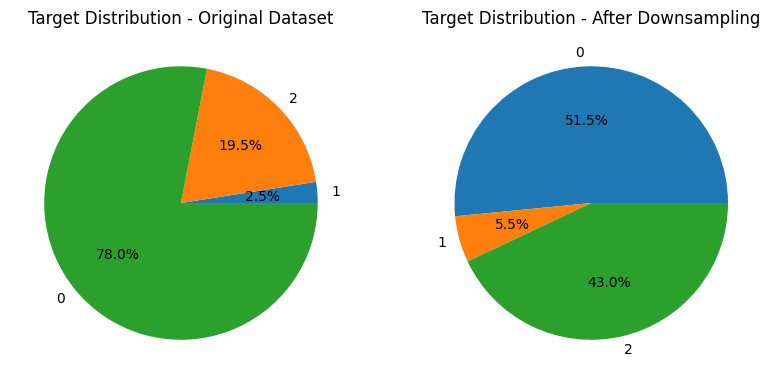

In [ ]:
# Original dataset
loan_status_count_original = df.groupby('target').count().toPandas()

plt.figure(figsize=(15, 6))

# Subplot 1 - Target Distribution before downsampling
plt.subplot(1, 3, 1)
plt.pie(loan_status_count_original['count'], labels=loan_status_count_original['target'], autopct='%1.1f%%')
plt.title('Target Distribution - Original Dataset')

# Downsampled dataset
loan_status_count_downsampled = df_downsampled.groupby('target').count().toPandas()

# Subplot 2 - Target Distribution after downsampling
plt.subplot(1, 3, 2)
plt.pie(loan_status_count_downsampled['count'], labels=loan_status_count_downsampled['target'], autopct='%1.1f%%')
plt.title('Target Distribution - After Downsampling')

plt.show()

In [41]:
df_downsampled.groupby('target').count()\
.show()

+------+------+
|target| count|
+------+------+
|     0|323258|
|     1| 34214|
|     2|268493|
+------+------+



# VectorAssembler

In [ ]:
df_downsampled.limit(3).toPandas()

,term,acc_now_delinq,annual_inc,application_type,dti,installment,int_rate,loan_amnt,purpose_encoded,addr_state_encoded,home_ownership_encoded,verification_status_encoded,grade_index,initial_list_status_encoded,target
0,36,0,32000,1,17,169.270004,13.33,5000.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)",0,2.0,1,0
1,36,0,32000,1,31,143.529999,13.99,4200.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0)",0,2.0,1,0
2,36,0,140000,1,6,63.130001,8.49,2000.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)",0,1.0,1,0


In [34]:
feature_cols = ['term',	'acc_now_delinq',	'annual_inc',
                'application_type',	'dti',	'installment',
                 'int_rate',	'loan_amnt',
                'grade_index',	'verification_status_encoded',
                'initial_list_status_encoded',
                'purpose_encoded',	'home_ownership_encoded']
target = ['target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")

df_downsampled = assembler.transform(df_downsampled)

In [ ]:
df_downsampled\
.select('features_to_scale', 'target')\
.show()

+--------------------+------+
|   features_to_scale|target|
+--------------------+------+
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
|(29,[0,2,3,4,5,6,...|     0|
+--------------------+------+
only showing top 20 rows



#MinMaxScaler

In [35]:
scaler = MinMaxScaler(inputCol="features_to_scale", outputCol="features")
scalerModel = scaler.fit(df_downsampled)
df_downsampled = scalerModel.transform(df_downsampled)

In [ ]:
df_downsampled\
.select('features', 'target')\
.show()

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                                                    |target|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|(29,[2,3,4,5,6,7,8,10,14,25],[0.0033406274195523014,1.0,0.032,0.07948444946157772,0.3380062261044095,0.09367088607594937,0.3333333333333333,1.0,1.0,1.0])                   |0     |
|(29,[2,3,4,5,6,7,8,9,10,14,25],[0.0043852263625017394,1.0,0.024,0.15542509080406253,0.3380062261044095,0.189873417721519,0.3333333333333333,1.0,1.0,1.0,1.0])               |0     |
|(29,[2,3,4,5,6,7,8,10,14,24],[0.014622296003406228,1.0,0.007,0.03246745697734716,0.123831

# Models

In [50]:
train_data, test_data = df_downsampled.randomSplit([0.8, 0.2], seed=42)
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure", labelCol="target")

## Logistic Regression

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'target')

# Trenowanie modelu
lrModel = lr.fit(train_data)

# Predykcja na danych testowych
predictions_lr = lrModel.transform(test_data)

f1_reg = f1_evaluator.evaluate(predictions_lr)
print("F1 for Logistic Regression: ", f1_reg)

F1 for Logistic Regression:  0.5931188602790636


## Random Forest

In [54]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')


rfModel = rf.fit(train_data)
predictions_rf = rfModel.transform(test_data)

accuracy = evaluator_accuracy.evaluate(predictions_rf)
f1_score = f1_evaluator.evaluate(predictions_rf)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.6121018295503485
F1 Score: 0.5949979310761154


## Grid Search & Cross Validation

In [ ]:
rf_model = RandomForestClassifier(featuresCol="features", labelCol="target")

paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [2, 10]) \
    .addGrid(rf_model.maxDepth, [5]) \
    .build()

crossval = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_data)

best_model = cvModel.bestModel


param_names = ["numTrees", "maxDepth"]
best_params = {param_name: cvModel.bestModel.getOrDefault(param_name)
               for param_name in param_names}

print(f'Model: {best_model},\nParametry: {best_params}')

estimator_param_maps = cvModel.getEstimatorParamMaps()
avg_metrics = cvModel.avgMetrics

for idx, param_map in enumerate(estimator_param_maps):
    metrics = avg_metrics[idx]
    print("Parametry:", param_map, '\n')
    print("Średnia metryka:", metrics, '\n')
    print("---")

Model: RandomForestClassificationModel: uid=RandomForestClassifier_07c654bf4912, numTrees=10, numClasses=3, numFeatures=29,
Parametry: {'numTrees': 10, 'maxDepth': 5}
Parametry: {Param(parent='RandomForestClassifier_07c654bf4912', name='numTrees', doc='Number of trees to train (>= 1).'): 2, Param(parent='RandomForestClassifier_07c654bf4912', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5} 

Średnia metryka: 0.5884188787745421 

---
Parametry: {Param(parent='RandomForestClassifier_07c654bf4912', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_07c654bf4912', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5} 

Średnia metryka: 0.5927458876700125 

---


## Neural Network

In [55]:
# input:29, 64 neurons in 1 hidden layer, 32 neurons in 2 hidden layer, outopt: 3
layers = [29, 64, 32, 3]
mlp = MultilayerPerceptronClassifier(layers=layers, labelCol="target", featuresCol="features", maxIter=100, seed=123)

model = mlp.fit(train_data)

predictions = model.transform(test_data)

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.6111846617644713
F1 Score: 0.594672243867977
